# Compute Cluster Power Spectrum, $P(k)$ with Nbodykit

Here I try to run `nbodykit` to compute the cluster power spectrum. 

Following this notebook:\
https://nbodykit.readthedocs.io/en/latest/cookbook/convpower.html \
https://github.com/bccp/nbodykit-cookbook/blob/master/recipes/fftpower.ipynb

## Installing Nobdykit

If you don't have the package it might take some time to install it. In the NERSC computer I had to create a special environement for nbodykit.

```
conda create --name nbodykit-env python=3.7 # or use python=2 for python 2.7*
source activate nbodykit-env
conda install -c bccp nbodykit
```

Then, to add to your jupyter notebook environement.
```
pip install ipykernel
python -m ipykernel install --user --name=nbodykit-env
```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !pip install nbodykit

In [3]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [4]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [5]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [6]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

## Loading the Catalog

In [7]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')

print('halo file name: %s'%floc.mock_nbody_fname)
data = FITSCatalog(floc.mock_nbody_fname)

print('Random file name: %s'%floc.mock_random_fname)
randoms = FITSCatalog(floc.mock_random_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_nbody.fits
Random file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0_randoms.fits


In [8]:
Nr = int(20*data.csize)
indices = np.random.randint(randoms.csize, size=Nr)
indices.sort()
randoms = randoms[indices]

## Estimating n(z)

A nice paper to understand the importance of the volume element in surveys:
https://arxiv.org/pdf/astro-ph/9304022.pdf

In [9]:
# fiducial cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)

# add Cartesian position column
data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
randoms['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)

Text(0, 0.5, '$n(z)$ $[h^{3} \\mathrm{Mpc}^{-3}]$')

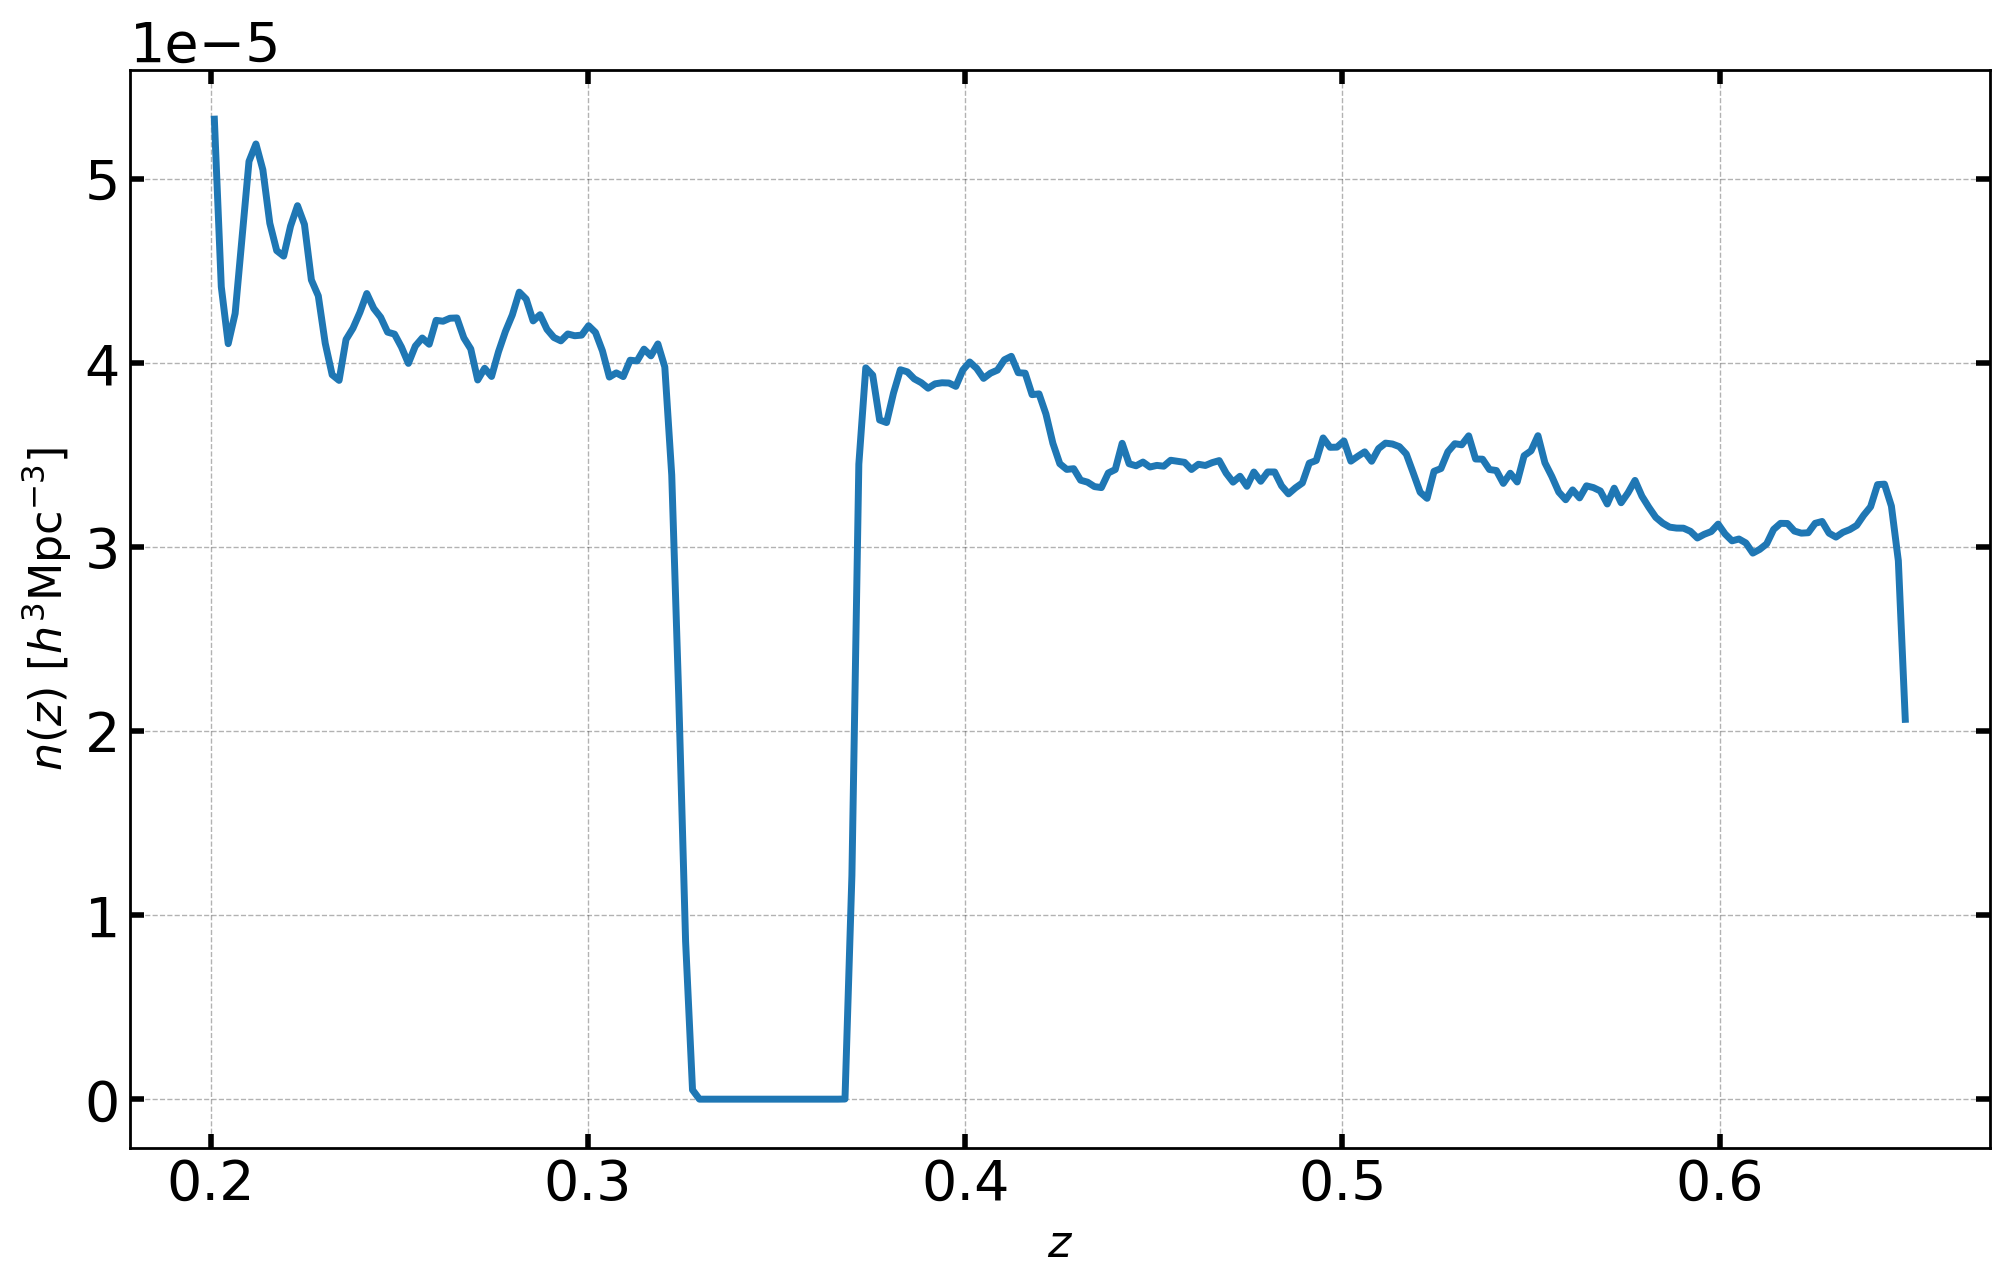

In [10]:
# the sky fraction, used to compute volume in n(z)
FSKY = 1. # a made-up value

# compute n(z) from the randoms
zhist = RedshiftHistogram(randoms, FSKY, cosmo, redshift='z')

# re-normalize to the total size of the data catalog
alpha = 1.0 * data.csize / randoms.csize

# add n(z) from randoms to the FKP source
nofz = InterpolatedUnivariateSpline(zhist.bin_centers, alpha*zhist.nbar)

# plot
plt.plot(zhist.bin_centers, alpha*zhist.nbar)
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$", fontsize=16)

In [11]:
# add the n(z) columns to the FKPCatalog
randoms['NZ'] = nofz(randoms['z'])
data['NZ'] = nofz(data['z'])

# add the weights
# data['Weight'] = np.ones(data.csize)
# randoms['Weight'] = randoms['weight']

In [12]:
# plt.hist(np.array(randoms['weight'])[::100])

In [13]:
# initialize the FKP source
fkp = FKPCatalog(data, randoms)

# print out the columns
print("columns in FKPCatalog = ", fkp.columns)

columns in FKPCatalog =  ['data/FKPWeight', 'data/NZ', 'data/Position', 'data/Selection', 'data/Value', 'data/Weight', 'data/dec', 'data/ra', 'data/z', 'randoms/FKPWeight', 'randoms/NZ', 'randoms/Position', 'randoms/Selection', 'randoms/Value', 'randoms/Weight', 'randoms/dec', 'randoms/ra', 'randoms/z']


## Adding FKP Weights

Here, we add a column ``FKPWeight`` that gives the appropriate FKP weight for each catalog. The FKP weights are given by:

$$
w_\mathrm{FKP} = \frac{1}{1 + n(z)P_0}.
$$

Here, we use a value of $P_0 = 2 \times 10^4 \ h^{-3} \mathrm{Mpc}^3$.

I took this value from: https://arxiv.org/pdf/1608.05446.pdf

In [14]:
fkp['data/FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
fkp['randoms/FKPWeight'] = 1.0 / (1 + fkp['randoms/NZ'] * 2e4)

In [15]:
data['FKPWeight'] = 1.0 / (1 + fkp['data/NZ'] * 2e4)
randoms['FKPWeight'] =1.0 / (1 + fkp['randoms/NZ'] * 2e4)

## Compute $P(k)$ Directly with Meshgrid

The main paremeter is `Nmesh` which is the size of the cubic meshigrid density estimator. Another paremeter to pay attention is the window type `tsc`.

In [16]:
# start the meshgrid density estimator in the box space of x,y and z
mesh = fkp.to_mesh(Nmesh=512, nbar='NZ', fkp_weight='FKPWeight', window='sym20')

In [ ]:
# compute the multipoles
r = ConvolvedFFTPower(mesh, poles=[0], dk=0.001, kmin=0.005)

no compensation applied for source 'first'
no compensation applied for source 'second'


In [ ]:
for key in r.attrs:
    print("%s = %s" % (key, str(r.attrs[key])))

### Measurements Results

#### Rolling Average

The bin size is a parameter that cannot be set to be logarithmic. For this reason i choose a ver low parameter in order to probe the large scales. However, our result is noisy due to the algorithm flutuations of the meshigrid density estimation. To have a better estimaton of the mean value I use two rolling averages for two different scales.

In [ ]:
P = r.poles['power_0'].real
P = P - r.poles.attrs['shotnoise']

In [ ]:
kvec = np.logspace(-3, np.log10(5.), 50)
isnan = np.isnan(np.log(P))
# isnan |= P<1e2
k, pk = r.poles['k'][~isnan], P[~isnan]
log_k, log_pk = np.log(k), np.log(pk)

from scipy.ndimage import uniform_filter1d
# rolling average
y = uniform_filter1d(pk, size=int(k.size/50))
y2 = uniform_filter1d(pk, size=int(k.size/7))
ix = np.where(k>0.22)[0]
y[ix] = y2[ix]

# fist points do with the average
# ix = np.where(k<0.3)[0]
log_pk = np.log(y)



In [ ]:
from scipy.interpolate import interp1d
pk_interp = interp1d(log_k, log_pk, bounds_error=False, kind='cubic')

pk_vec = np.exp(pk_interp(np.log(kvec)))
isnan = ~np.isnan(pk_vec)
pk_vec = pk_vec[isnan]
kvec = kvec[isnan]


In [ ]:
import hankl
print("Using hankel v{}".format(hankl.__version__))

# s, xi0 = hankl.P2xi(kvec, pk_vec, l=0)
s, xi0 = hankl.P2xi(kvec, pk_vec, l=0)

In [ ]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
poles = r.poles
plt.loglog()
for ell in [0]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - poles.attrs['shotnoise']
    plt.plot(poles['k'], poles['k']*P, '.', color='lightgray', label=label)

    
plt.plot(kvec, pk_vec*kvec, 'k')
plt.plot(k, k*y, 'r--')
# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \times P_\ell$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.005, 0.8)
plt.title('Buzzar Mock - Cluster P(k)')

plt.subplot(1,2,2)
# plt.xscale('log')
plt.loglog()
plt.plot(s, xi0, 'k')
# plt.ylim(-60,30)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$\xi_{0}(r)$')
# plt.legend()
plt.title('Hankel Transformation')
plt.xlim(1.,220)
plt.subplots_adjust(wspace=0.25)
fig.tight_layout()
plt.savefig('pk_mock_lgt5.png', transparent=False, facecolor='w', dpi=150)

In [ ]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

In [ ]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.2, 0.65], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 1000)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 1000)


In [ ]:
b=1.

plt.plot(kvec, pk_vec*kvec, 'k', lw=3)
for i, (redshift, line) in enumerate(zip(z_lin,['-','--'])):
    plt.loglog(kh_lin, b**2*pk_lin[i,:], color='gray', ls = line)
    plt.loglog(kh_nonlin, b**2*pk_nonlin[i,:], color='r', ls = line)

plt.xlabel('k/h Mpc');
plt.ylabel(r'$P_{mm}(k)$')
plt.legend(['Mock Buzzard: $\lambda>5$','linear','non-linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z_lin));

plt.savefig('pk_mock_lgt5_camb.png', transparent=False, facecolor='w', dpi=150)

In [ ]:
# My randoms don't work